Things tested:

- Instantiation of the three monitors `BunchMonitor`, `SliceMonitor`, `ParticleMonitor`.
- dump(beam) method for all the three.
- read data from file. Plot example data from `BunchMonitor`, `SliceMonitor`, `ParticleMonitor`.
- SliceMonitor: does it handle/request `SliceSet` instances correctly?
- Buffers are on for `BunchMonitor` and `SliceMonitor` instances.

Look at one of the files in hdfview to check the units, attributes, ...

# general imports

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(111)

import h5py as hp

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
# sets the PyHEADTAIL directory etc.
try:
    from settings import *
except:
    pass

# PyHEADTAIL imports

In [3]:
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.particles.slicing import UniformBinSlicer

PyHEADTAIL v1.10.5.271




# Setting up the machine and functions

In [4]:
# Basic parameters.
n_turns = 500
n_segments = 5
n_macroparticles = 500

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376
alpha_0 = 0.0003225

# Parameters for transverse map.
s = np.arange(0, n_segments + 1) * C / n_segments

alpha_x = alpha_x_inj * np.ones(n_segments)
beta_x = beta_x_inj * np.ones(n_segments)
D_x = np.zeros(n_segments)

alpha_y = alpha_y_inj * np.ones(n_segments)
beta_y = beta_y_inj * np.ones(n_segments)
D_y = np.zeros(n_segments)

# HELPERS
def read_all_data(bfile, sfile, pfile):
    bunchdata = hp.File(bfile + '.h5')
    slicedata = hp.File(sfile + '.h5')
    particledata = hp.File(pfile + '.h5part')

    # Bunchdata
    bdata = bunchdata['Bunch']
    
    n_turns = len(bdata['mean_x'])
    _ = np.empty(n_turns)
    for key in bdata.keys():
        _[:] = bdata[key][:]
    
    # Slicedata
    sdata = slicedata['Slices']
    sbdata = slicedata['Bunch']
    
    n_turns = len(sbdata['mean_x'])
    _ = np.empty(n_turns)
    for key in sbdata.keys():
        _[:] = sbdata[key][:]
    
    n_slices, n_turns = sdata['mean_x'].shape
    _ = np.empty((n_slices, n_turns))
    for key in sdata.keys():
        _[:,:] = sdata[key][:,:]

    # Particledata
    pdata = particledata['Step#0']
    n_particles = len(pdata['x'])
    n_steps = len(particledata.keys())
    _ = np.empty(n_particles)
    
    for i in range(n_steps):
        step = 'Step#%d' % i
        for key in particledata[step].keys():
            _[:] = particledata[step][key][:]
    
    bunchdata.close()
    slicedata.close()
    particledata.close()

def read_n_plot_data(bfile, sfile, pfile):
    bunchdata = hp.File(bfile + '.h5')
    slicedata = hp.File(sfile + '.h5')
    particledata = hp.File(pfile + '.h5part')

    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax1.plot(bunchdata['Bunch']['mean_x'][:])
    ax1.set_xlabel('turns', fontsize=20)
    ax1.set_ylabel('mean_x of bunch', fontsize=20)
    ax1.set_title('BunchMonitor', fontsize=20)
    ax2.plot(slicedata['Slices']['mean_x'][:,:])
    ax2.set_xlabel('turns', fontsize=20)
    ax2.set_ylabel('mean_x of slices', fontsize=20)
    ax2.set_title('SliceMonitor', fontsize=20)
    ax3.plot(particledata['Step#0']['id'][:], 
             particledata['Step#0']['x'][:])
    ax3.set_xlabel('particle id', fontsize=20)
    ax3.set_ylabel('x coordinate', fontsize=20)
    ax3.set_title('ParticleMonitor', fontsize=20)
    
    plt.tight_layout()
    plt.show()
    
    bunchdata.close()
    slicedata.close()
    particledata.close()

def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, alpha_0, Q_s, R):
    intensity = 1.05e11
    sigma_z = 0.059958
    gamma = 3730.26
    eta = alpha_0 - 1. / gamma**2
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = eta * R / Q_s

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e)
    
    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    
    return bunch

# Let's go

Instantiate BunchMonitor, SliceMonitor and ParticleMonitor and dump data to file:

In [5]:
bunch = generate_bunch(
    n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,
    alpha_0, Q_s, R)

trans_map = TransverseMap(
    s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y)

# Slicer config for SliceMonitor.
unibin_slicer = UniformBinSlicer(n_slices=10, n_sigma_z=None, z_cuts=None)

# Monitors
bunch_filename = 'bunch_mon'
slice_filename = 'slice_mon'
particle_filename = 'particle_mon'

bunch_monitor = BunchMonitor(
    filename=bunch_filename, n_steps=n_turns, 
    parameters_dict={'Q_x': Q_x}, write_buffer_every=20
)
slice_monitor = SliceMonitor(
    filename=slice_filename, n_steps=n_turns, 
    slicer=unibin_slicer, parameters_dict={'Q_x': Q_x},
    write_buffer_every=20
)
particle_monitor = ParticleMonitor(
    filename=particle_filename, stride=10, 
    parameters_dict={'Q_x': Q_x}
)

arrays_dict = {}
map_ = trans_map

for i in range(n_turns):
    for m_ in map_:
        m_.track(bunch)
    bunch_monitor.dump(bunch)
    slice_monitor.dump(bunch)
    
    slice_set_pmon = bunch.get_slices(unibin_slicer)
    arrays_dict.update({'slidx': slice_set_pmon.slice_index_of_particle, 'zz': bunch.z})
    particle_monitor.dump(bunch, arrays_dict)

Try opening the files and reading out all data:

In [6]:
read_all_data(bunch_filename, slice_filename, particle_filename)

Plot monitored data examples. Note that the `ParticleMonitor` only records every $10^\text{th}$ particle (due to the kwarg `stride`=10).

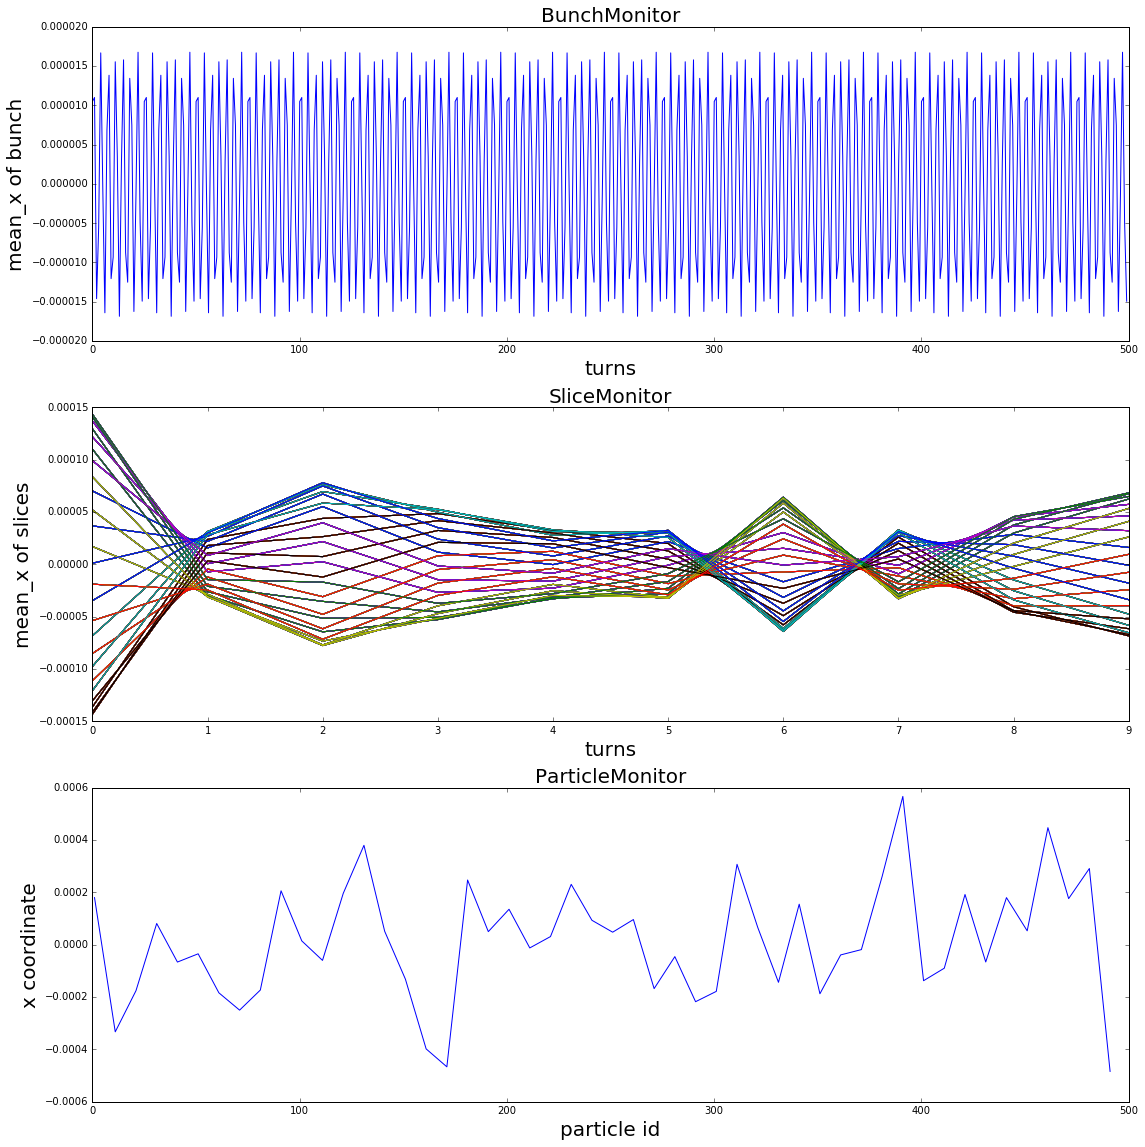

In [7]:
read_n_plot_data(bunch_filename, slice_filename, particle_filename)

Remove created monitor files:

In [8]:
import os
os.remove(bunch_filename + '.h5')
os.remove(slice_filename + '.h5')
os.remove(particle_filename + '.h5part')